<span style="font-size:40px">LLM generated text detection</span>

# Exploratory Data Analysis

In [1]:
#pip install datasets

In [103]:
from collections import Counter
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from scipy.sparse import hstack
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy

In [104]:
from datasets import load_dataset

dataset = load_dataset("Hello-SimpleAI/HC3", "all")

In [105]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})


In [106]:
df = dataset["train"].to_pandas()

In [107]:
df.head()

,id,question,human_answers,chatgpt_answers,source
0,0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,reddit_eli5
1,1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,reddit_eli5
2,2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,reddit_eli5
3,3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,reddit_eli5
4,4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,reddit_eli5


In [108]:
#Visualize origin sources from human answers
df['source'].unique()

array(['reddit_eli5', 'open_qa', 'wiki_csai', 'finance', 'medicine'],
      dtype=object)

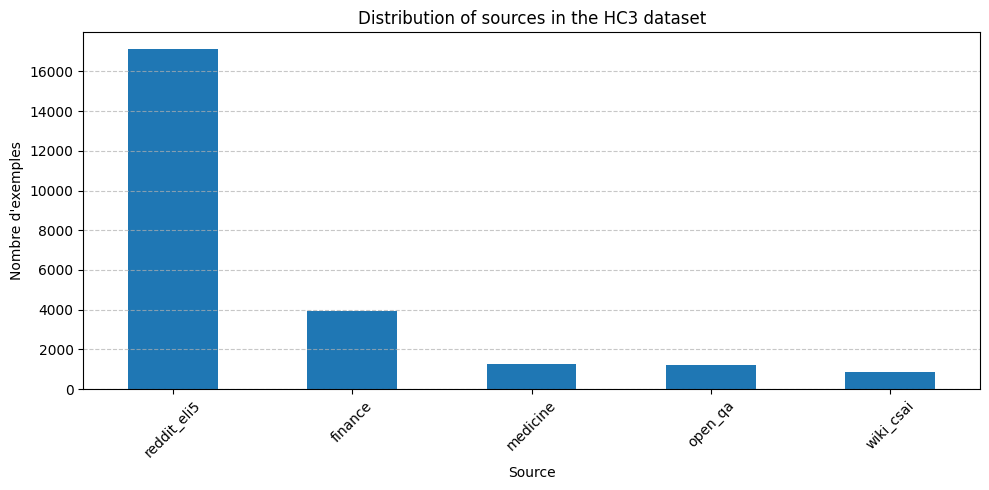

In [109]:
# Count the occurrences of each source
source_counts = df['source'].value_counts()

# barplot
plt.figure(figsize=(10, 5))
source_counts.plot(kind='bar')

plt.title("Distribution of sources in the HC3 dataset")
plt.xlabel("Source")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Distribution of sources in the HC3 dataset.png')
plt.show()

In [110]:
sources = df['source'].unique()

for source in sources:
    print(f"\n===== Source: {source} =====")
    subset = df[df['source'] == source].head(5)
    display(subset[['question', 'human_answers', 'chatgpt_answers']])


===== Source: reddit_eli5 =====


,question,human_answers,chatgpt_answers
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...



===== Source: open_qa =====


,question,human_answers,chatgpt_answers
17112,what composer used sound mass,"[Composers and works include Barbara Kolb , Pa...",[Sound mass is a term used to describe a type ...
17113,where did the persian war take place,[The Greco-Persian Wars (also often called the...,[The Persian Wars were a series of conflicts f...
17114,what are add ons,"[Plug-in (computing) , a piece of software whi...","[Add-ons, also known as extensions or plug-ins..."
17115,how does a dredge work?,[Dredging is an excavation activity or operati...,[A dredge is a piece of equipment that is used...
17116,what classes are considered humanities,[The humanities are academic disciplines that ...,[Humanities are academic disciplines that stud...



===== Source: wiki_csai =====


,question,human_answers,chatgpt_answers
18299,"Please explain what is ""Animal cognition""",[Animal cognition encompasses the mental capac...,[Animal cognition refers to the mental capacit...
18300,"Please explain what is ""Human intelligence""",[Human intelligence is the intellectual capabi...,[Human intelligence is the mental ability to t...
18301,"Please explain what is ""Oxford English Diction...",[The Oxford English Dictionary (OED) is the fi...,[The Oxford English Dictionary (OED) is a comp...
18302,"Please explain what is ""Oxford University Press""",[Oxford University Press (OUP) is the universi...,[Oxford University Press (OUP) is a department...
18303,"Please explain what is ""AI applications""",[Artificial intelligence (AI) has been used in...,[AI applications are computer systems that are...



===== Source: finance =====


,question,human_answers,chatgpt_answers
19141,Historical P/E ratios of small-cap vs. large-c...,[There is most likely an error in the WSJ's da...,[Historical price-to-earnings (P/E) ratios for...
19142,Should you co-sign a personal loan for a frien...,[I know this question has a lot of answers alr...,[Co-signing a personal loan for a friend or fa...
19143,Should I avoid credit card use to improve our ...,[If you pay it off before the cycle closes it ...,[It can be a good idea to avoid using credit c...
19144,Difference between 'split and redemption' of s...,[It is the first time I encounter redemption p...,[Share split and redemption are two different ...
19145,Pros & cons of investing in gold vs. platinum?,[Why Investors Buy Platinum is an old (1995) a...,[Gold and platinum are both precious metals th...



===== Source: medicine =====


,question,human_answers,chatgpt_answers
23074,Does Primolut N taken during pregnancy affect ...,"[Hi, Thanks for the query. I understand yo...",[It is not recommended to use Primolut N durin...
23075,Bloating and pain on right lower abdomen. Shou...,"[Hello,Thanks for the query to H.C.M. Forum.Pa...",[If you are experiencing abdominal pain and bl...
23076,Is chest pain related to intake of clindamycin...,"[Hello, The use of Clindamycin can cause stoma...",[It is possible that chest pain could be relat...
23077,Q. Noticed a yellowish sag in the gums of my 1...,[Hello. Revert back with the photos to a denti...,[It is difficult to accurately diagnose a cond...
23078,"Suggest remedy for low grade fever, hot and co...","[Hi Dear,Welcome to Healthcaremagic Team.Under...",[I'm sorry to hear that you're feeling sick. I...


The medical source human answers exhibits a clear bias: each sentence starts with a greeting, making it much easier to detect.
In the following, we will remove this part from the dataset.

In [111]:
df = df[df['source'] != 'medicine']

In [112]:
type(df["human_answers"].iloc[0])

numpy.ndarray

In [113]:
import numpy as np
df['human_answers'] = df['human_answers'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df['chatgpt_answers'] = df['chatgpt_answers'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [114]:
df['human_answers'].iloc[2]

["The way it works is that old TV stations got a certain amount of bandwidth to replace their old analog TV stations . However , HD takes up more bandwidth then SD - so the stations can choose between 2 or 3 HD stations , or like 7 or 8 SD stations ( or a mix of both ) They can do a bunch of SD stations and make more money in advertizing by running 7 or 8 different reruns of old SD TV shows at a time In fact , those stations often got permanent rights to show an unlimited number of reruns of old syndicated shows in perpetuity . That means they do n't even have to pay anyone to air old eppisodes of _ Star Trek _ or _ Alf _ So basically it 's free money for them , based on being around for a long , long time and having their old rights get upgraded as new technology comes out .",
 "HD does n't look like anything at all on an SD TV . An old SD television ca n't even process the HD signal . We still have SD channels because there are still SD televisions out there .",
 "There are a few rea

In [115]:
len(df['human_answers'].iloc[2])

3

List of multiple answers. In the following, we will only keep the first one

In [116]:
# Keep only the rows where chatgpt_answers is not empty.
df = df[df['chatgpt_answers'].apply(lambda x: len(x) > 0)]


In [117]:
# Replace the list with only the first answer.
df['human_answers'] = df['human_answers'].apply(lambda x: str(x[0]))
df['chatgpt_answers'] = df['chatgpt_answers'].apply(lambda x: str(x[0]))

print(df['human_answers'])

0        Basically there are many categories of " Best ...
1        salt is good for not dying in car crashes and ...
2        The way it works is that old TV stations got a...
3        You ca n't just go around assassinating the le...
4        Wanting to kill the shit out of Germans drives...
                               ...                        
23069    Yes.  For $15 it's not worth anyone's time to ...
23070    Another source of insurance can be through the...
23071    From Schwab -  What are the eligibility requir...
23072    Your credit card limit is nothing more than a ...
23073    I am a huge fan of jim Cramer and while you ma...
Name: human_answers, Length: 22619, dtype: object


# Structural analysis

## Length of answers (Human vs ChatGPT)

In [118]:
def count_words(text):
    return len(text.split()) if isinstance(text, str) else 0
# Longueur moyenne des réponses humaines par ligne
df['human_length']  = df['human_answers'].apply(count_words)

# Longueur des réponses ChatGPT
df['chatgpt_length'] = df['chatgpt_answers'].apply(count_words)

# Statistiques globales
stats = df[['human_length', 'chatgpt_length']].describe()
print(stats)

       human_length  chatgpt_length
count  22619.000000    22619.000000
mean     151.607498      177.492329
std      180.341570       58.407924
min        2.000000        1.000000
25%       48.000000      138.000000
50%       97.000000      177.000000
75%      190.000000      214.000000
max     7904.000000      639.000000


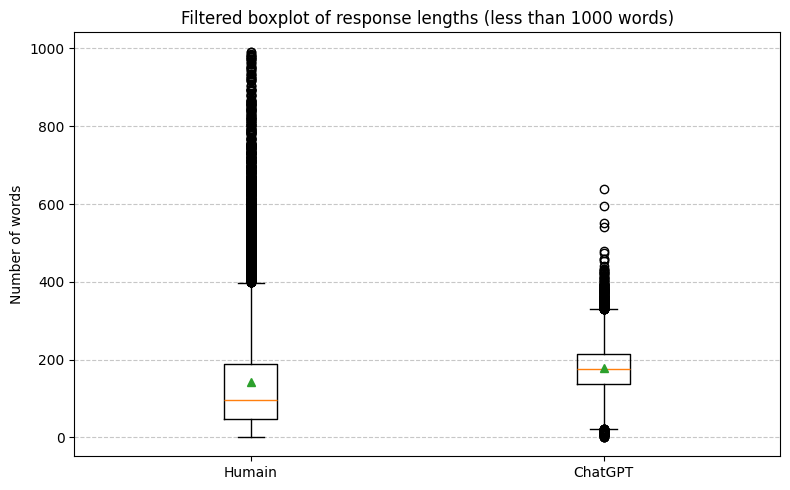

In [120]:
filtered_df = df[(df['human_length'] < 1000) & (df['chatgpt_length'] < 1000)]
plt.figure(figsize=(8, 5))
plt.boxplot(
    [filtered_df['human_length'].dropna(), filtered_df['chatgpt_length'].dropna()],
    tick_labels=['Humain', 'ChatGPT'],
    showmeans=True
)

plt.title("Filtered boxplot of response lengths (less than 1000 words)")
plt.ylabel("Number of words")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Filtered_boxplot_of_response_lengths.png')
plt.show()

### Interpretation
- Human responses show greater variability in length, ranging from very short to very long. This reflects a natural heterogeneity in writing styles and levels of detail.
- ChatGPT responses are generally longer on average but also more homogeneous, mostly falling within the 150–250 word range.
- This consistency may be explained by the way models like ChatGPT optimize token usage, as each generation is priced based on the number of tokens used. This encourages responses that are concise yet complete.
- There are also fewer outliers among ChatGPT responses, suggesting a more "calibrated" generation compared to the natural variability seen in human writing.

One might think that very long sentences could be characteristic of human writing.
Is this therefore a useful signal?

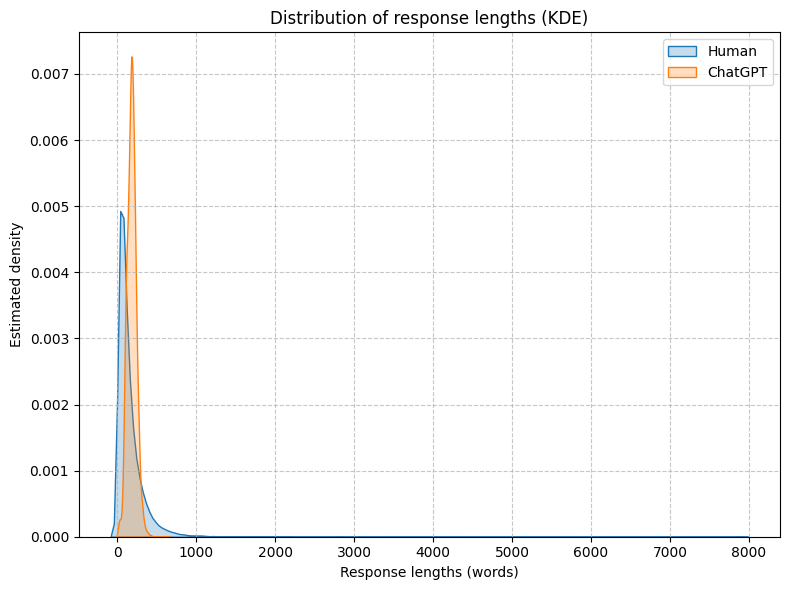

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

human_lengths = df['human_length']
chatgpt_lengths = df['chatgpt_length']

# KDE
plt.figure(figsize=(8,6))
sns.kdeplot(human_lengths, label='Human', fill=True, bw_adjust=1.2)
sns.kdeplot(chatgpt_lengths, label='ChatGPT', fill=True, bw_adjust=1.2)

plt.xlabel('Response lengths (words)')
plt.ylabel('Estimated density')
plt.title('Distribution of response lengths (KDE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('response_lengths_(KDE).png')
plt.show()

## Average number of sentences per answer (Human vs ChatGPT)

In [123]:
nltk.download('punkt')
def count_sentences(text):
    if isinstance(text, str):
        return len(sent_tokenize(text))
    return 0

# Appliquer aux réponses humaines (moyenne sur toutes les réponses)
def avg_sentences(resp):
    if isinstance(resp, str) and len(resp) > 0:
        return count_sentences(resp)
    return 0

df['human_num_sentences'] = df['human_answers'].apply(avg_sentences)
df['chatgpt_num_sentences'] = df['chatgpt_answers'].apply(avg_sentences)

[nltk_data] Downloading package punkt to /Users/donmello/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
# Statistiques globales
stats_sentences = df[['human_num_sentences', 'chatgpt_num_sentences']].describe()
print(stats_sentences)

       human_num_sentences  chatgpt_num_sentences
count         22619.000000           22619.000000
mean              7.312215               7.235024
std               8.611354               2.936778
min               1.000000               1.000000
25%               3.000000               5.000000
50%               5.000000               7.000000
75%               9.000000               9.000000
max             361.000000              32.000000


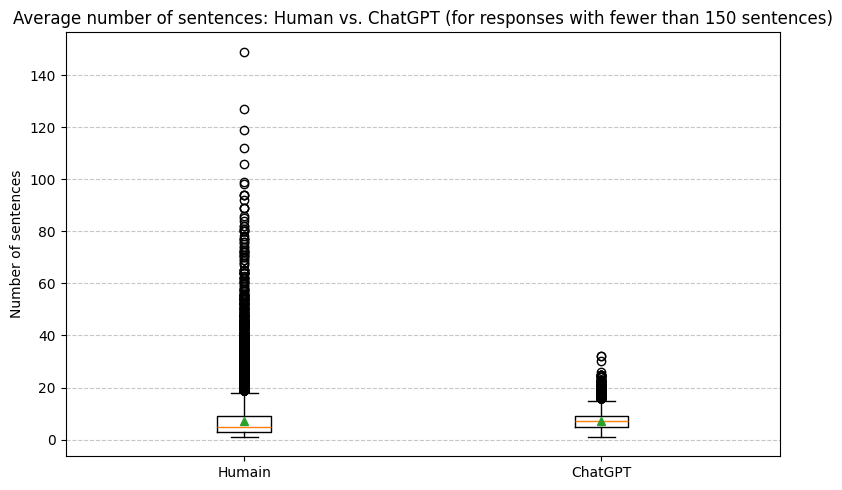

In [125]:
filtered_df = df[(df['human_num_sentences'] < 150) & (df['chatgpt_num_sentences'] < 150)]
plt.figure(figsize=(8, 5))
plt.boxplot(
    [filtered_df['human_num_sentences'].dropna(), filtered_df['chatgpt_num_sentences'].dropna()],
    tick_labels=['Humain', 'ChatGPT'],
    showmeans=True
)

plt.title("Average number of sentences: Human vs. ChatGPT (for responses with fewer than 150 sentences)")
plt.ylabel("Number of sentences")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Average number of sentences: Human vs. ChatGPT (for responses with fewer than 150 sentences).png')
plt.show()

Same analysis as for the number of words.

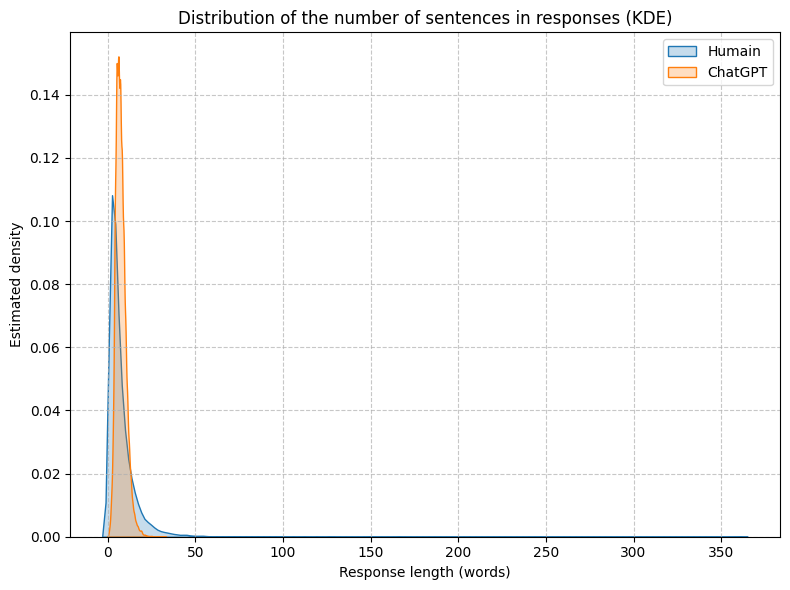

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt


human_lengths = df['human_num_sentences']
chatgpt_lengths = df['chatgpt_num_sentences']

# KDE
plt.figure(figsize=(8,6))
sns.kdeplot(human_lengths, label='Humain', fill=True, bw_adjust=1.2)
sns.kdeplot(chatgpt_lengths, label='ChatGPT', fill=True, bw_adjust=1.2)

plt.xlabel('Response length (words)')
plt.ylabel('Estimated density')
plt.title('Distribution of the number of sentences in responses (KDE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Distribution of the number of sentences in responses (KDE).png')
plt.show()

# Lexical Analysis

In [127]:
# Tokenisation : split + cleaning
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.split()

# Extraire toutes les réponses humaines en un seul texte
human_tokens = []
for resp in df['human_answers']:
    if isinstance(resp, str):
        human_tokens.extend(tokenize(resp))

# Réponses ChatGPT
chatgpt_tokens = []
for resp in df['chatgpt_answers']:
    if isinstance(resp, str):
        chatgpt_tokens.extend(tokenize(resp))

In [128]:
# Compter les fréquences
human_freq = Counter(human_tokens)
chatgpt_freq = Counter(chatgpt_tokens)

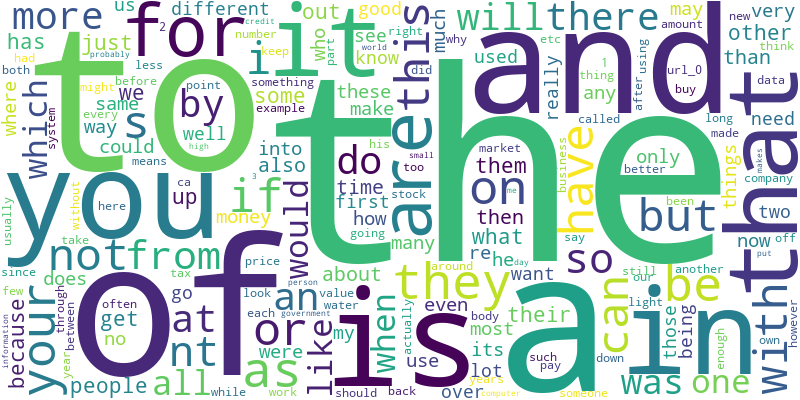

In [131]:
# Générer les wordclouds
image_human = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(human_freq).to_image()
image_human

In [132]:
image_human.save('mon_wordcloud_human.png')

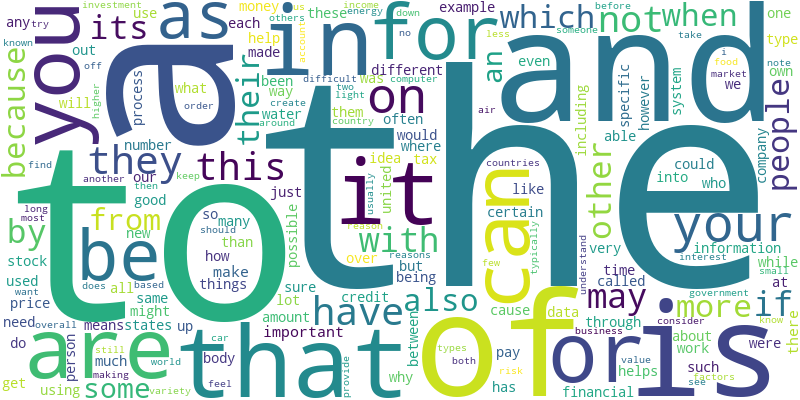

In [135]:
image_GPT = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(chatgpt_freq).to_image()
image_GPT

In [134]:
image_GPT.save('mon_wordcloud_GPT.png')

Too many Part-of-Speech (POS) words, making it too noisy to extract meaningful signals. In the following, we will remove them.

In [34]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.1 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [140]:
import spacy
from collections import Counter
from tqdm import tqdm

# English model
nlp = spacy.load("en_core_web_sm")

# POS to exclude
excluded_pos = {"DET", "ADP", "CCONJ", "SCONJ", "PUNCT", "PRON", "PART", "SPACE"}

# Filtering
def extract_content_words(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [
        token.lemma_.lower()
        for token in doc
        if token.pos_ not in excluded_pos and not token.is_stop and token.is_alpha
    ]

# Apply to all human responses
human_tokens = []
for text in tqdm(df['human_answers']):
    if isinstance(text, str):
        human_tokens.extend(extract_content_words(text))

# The same here
chatgpt_tokens = []
for text in tqdm(df['chatgpt_answers']):
    if isinstance(text, str):
        chatgpt_tokens.extend(extract_content_words(text))

# Top 20 mots
top20_human = Counter(human_tokens).most_common(20)
top20_chatgpt = Counter(chatgpt_tokens).most_common(20)

print("Top 20 mots humains :", top20_human)
print("Top 20 mots ChatGPT :", top20_chatgpt)
top_human = Counter(human_tokens).most_common(20)
top_chatgpt = Counter(chatgpt_tokens).most_common(20)

print("Top 20 mots humains :", top_human)
print("Top 20 mots ChatGPT :", top_chatgpt)

100%|█████████████████████████████████████| 22619/22619 [05:31<00:00, 68.18it/s]


Top 20 mots humains : [('people', 8523), ('time', 7662), ('thing', 5857), ('way', 5323), ('money', 5315), ('pay', 5189), ('need', 5105), ('know', 5078), ('year', 4928), ('use', 4854), ('want', 4596), ('good', 4575), ('go', 4495), ('work', 4458), ('mean', 4148), ('lot', 4017), ('think', 3882), ('company', 3833), ('different', 3717), ('number', 3615)]
Top 20 mots ChatGPT : [('people', 16264), ('help', 13888), ('use', 11752), ('important', 11577), ('way', 10950), ('different', 10180), ('time', 9703), ('include', 7748), ('need', 7605), ('good', 7383), ('company', 7033), ('work', 6525), ('type', 6383), ('example', 6358), ('cause', 6268), ('mean', 6253), ('financial', 5991), ('pay', 5972), ('body', 5964), ('stock', 5948)]
Top 20 mots humains : [('people', 8523), ('time', 7662), ('thing', 5857), ('way', 5323), ('money', 5315), ('pay', 5189), ('need', 5105), ('know', 5078), ('year', 4928), ('use', 4854), ('want', 4596), ('good', 4575), ('go', 4495), ('work', 4458), ('mean', 4148), ('lot', 4017

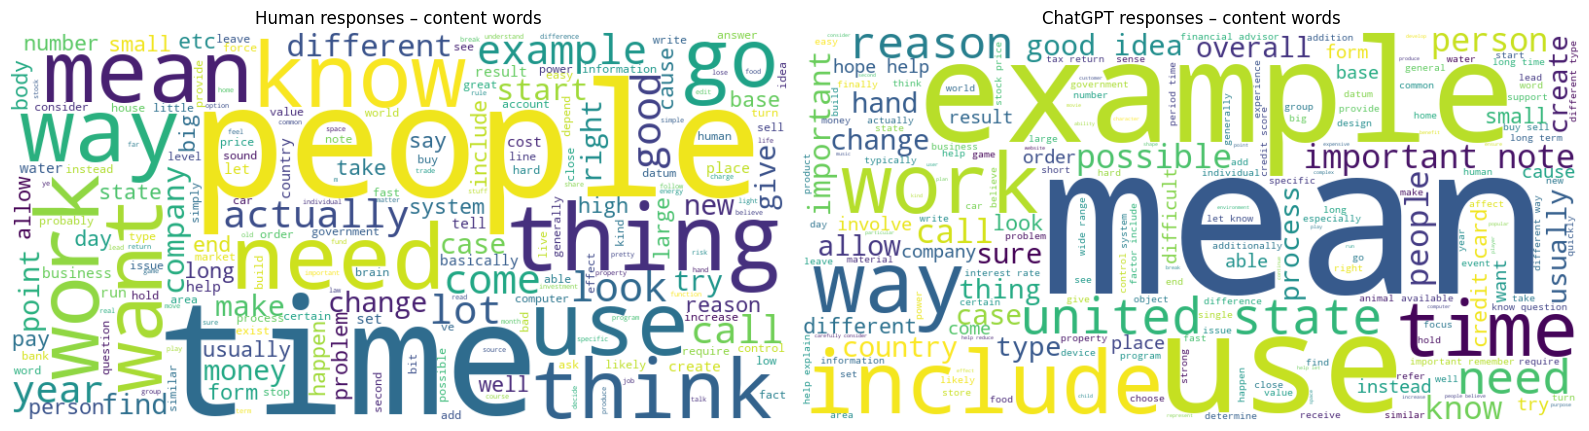

In [144]:
# Create text strings from tokens
human_text = " ".join(human_tokens)
chatgpt_text = " ".join(chatgpt_tokens)

# Generate the Word Clouds
wordcloud_human = WordCloud(width=800, height=400, background_color='white').generate(human_text)
wordcloud_chatgpt = WordCloud(width=800, height=400, background_color='white').generate(chatgpt_text)


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_human, interpolation='bilinear')
plt.axis('off')
plt.title("Human responses – content words")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_chatgpt, interpolation='bilinear')
plt.axis('off')
plt.title("ChatGPT responses – content words")

plt.tight_layout()

# Save the figure BEFORE plt.show()
plt.savefig('comparaison_wordclouds.png', bbox_inches='tight', dpi=300)

plt.show()

In [145]:
# TTR (type-token ratio)
def type_token_ratio(tokens):
    return len(set(tokens)) / len(tokens) if tokens else 0

print("TTR human :", type_token_ratio(human_tokens))
print("TTR ChatGPT :", type_token_ratio(chatgpt_tokens))

TTR human : 0.02942055810794975
TTR ChatGPT : 0.014043469435501311


### Interpretation

The **TTR** (Type-Token Ratio) is defined as:

$$
\text{TTR} = \frac{\text{Number of unique words}}{\text{Total number of words}}
$$

- Human TTR ≈ 0.03
- ChatGPT TTR ≈ 0.01

The TTR measures lexical diversity: the higher the ratio, the more varied the vocabulary.

- Human responses demonstrate greater lexical richness, with more synonyms and varied phrasing.
- ChatGPT responses are more repetitive, characterized by a more uniform style and a higher frequency of certain words and expressions.

**Conclusion:** The TTR is a strong indicator for distinguishing between human-written and AI-generated texts.

We will now analyse POS to see if we can extract meaningfull signals 

In [146]:
# Extract POS
def get_pos_tags(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [token.pos_ for token in doc if token.is_alpha]  # uniquement les mots alphabétiques

# Human POS Table
human_pos_tags = []
for text in tqdm(df['human_answers']):
    if isinstance(text, str):
        human_pos_tags.extend(get_pos_tags(text))

# The same for GPT
chatgpt_pos_tags = []
for text in tqdm(df['chatgpt_answers']):
    if isinstance(text, str):
        chatgpt_pos_tags.extend(get_pos_tags(text))

100%|█████████████████████████████████████| 22619/22619 [05:34<00:00, 67.60it/s]


In [147]:
# Count POS
human_pos_counts = Counter(human_pos_tags)
chatgpt_pos_counts = Counter(chatgpt_pos_tags)

print("Top POS humains :", human_pos_counts.most_common())
print("\nTop POS ChatGPT :", chatgpt_pos_counts.most_common())

Top POS humains : [('NOUN', 661169), ('VERB', 397130), ('ADP', 327156), ('DET', 304760), ('PRON', 297028), ('ADJ', 241561), ('AUX', 199552), ('ADV', 179155), ('CCONJ', 108322), ('PROPN', 97748), ('SCONJ', 87676), ('PART', 76793), ('NUM', 14508), ('INTJ', 4749), ('X', 2794), ('SYM', 157), ('PUNCT', 124)]

Top POS ChatGPT : [('NOUN', 948714), ('VERB', 532953), ('ADP', 425341), ('DET', 417273), ('ADJ', 349432), ('PRON', 333792), ('AUX', 299793), ('CCONJ', 184222), ('ADV', 151427), ('PART', 142045), ('SCONJ', 118844), ('PROPN', 95805), ('NUM', 13139), ('INTJ', 2550), ('X', 242), ('SYM', 120), ('PUNCT', 66)]


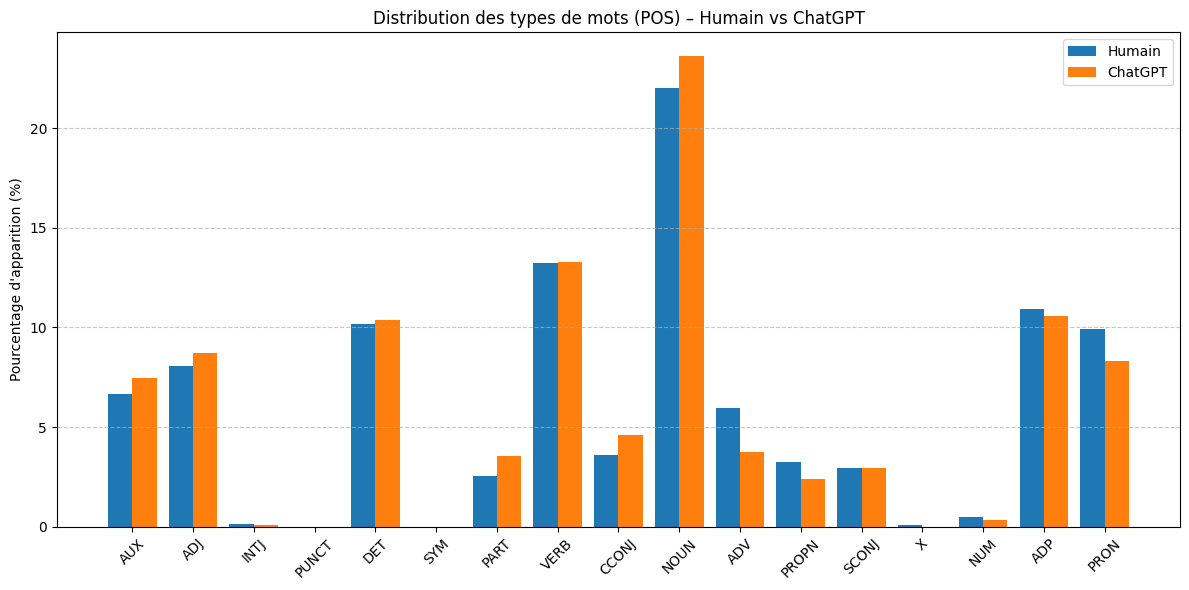

In [148]:
# Préparer les données
all_pos_tags = list(set(human_pos_counts.keys()) | set(chatgpt_pos_counts.keys()))
human_freqs = [human_pos_counts.get(tag, 0) for tag in all_pos_tags]
chatgpt_freqs = [chatgpt_pos_counts.get(tag, 0) for tag in all_pos_tags]

# Normaliser en pourcentage
human_total = sum(human_freqs)
chatgpt_total = sum(chatgpt_freqs)

human_freqs = [f / human_total * 100 for f in human_freqs]
chatgpt_freqs = [f / chatgpt_total * 100 for f in chatgpt_freqs]

# Affichage comparatif
x = range(len(all_pos_tags))
plt.figure(figsize=(12,6))
plt.bar(x, human_freqs, width=0.4, label='Humain', align='center')
plt.bar([i + 0.4 for i in x], chatgpt_freqs, width=0.4, label='ChatGPT', align='center')
plt.xticks([i + 0.2 for i in x], all_pos_tags, rotation=45)
plt.ylabel("Pourcentage d'apparition (%)")
plt.title("Distribution des types de mots (POS) – Humain vs ChatGPT")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Model based prediction

## Random Baseline

In [232]:
# Texts and labels
texts = df['human_answers'].tolist() + df['chatgpt_answers'].tolist()
y = [0] * len(df) + [1] * len(df)

# Split train/test
texts_train, texts_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)


In [233]:
len(texts_test)

9048

In [234]:
# Dummy classifier (random prediction)
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(np.zeros((len(y_train), 1)), y_train)  # Les features sont inutiles pour dummy, donc on met des zéros

# predictions
y_dummy_pred = dummy.predict(np.zeros((len(y_test), 1)))
y_dummy_proba = dummy.predict_proba(np.zeros((len(y_test), 1)))[:, 1]

# Metrics
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

metrics_dummy = get_metrics(y_test, y_dummy_pred, y_dummy_proba)

print("=== Random Baseline Results ===")
for k, v in metrics_dummy.items():
    print(f"{k}: {v:.4f}")

=== Random Baseline Results ===
Accuracy: 0.5000
Precision: 0.5000
Recall: 0.4978
F1-score: 0.4989
ROC AUC: 0.5000


At the same time, this also confirms that the test set is balanced.

### Lasso Logistic Regression

In [235]:
df.columns

Index(['id', 'question', 'human_answers', 'chatgpt_answers', 'source',
       'human_length', 'chatgpt_length', 'human_num_sentences',
       'chatgpt_num_sentences', 'human_ttr', 'chatgpt_ttr'],
      dtype='object')

In [236]:
def compute_ttr(text):
    if isinstance(text, str):
        words = text.lower().split()
        return len(set(words)) / len(words) if len(words) > 0 else 0
    return 0

In [237]:
df['human_ttr'] = df['human_answers'].apply(compute_ttr)
df['chatgpt_ttr'] = df['chatgpt_answers'].apply(compute_ttr)

In [238]:
df

,id,question,human_answers,chatgpt_answers,source,human_length,chatgpt_length,human_num_sentences,chatgpt_num_sentences,human_ttr,chatgpt_ttr
0,0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5,134,207,8,7,0.485075,0.449275
1,1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5,41,199,2,8,0.756098,0.597990
2,2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5,166,146,3,9,0.596386,0.575342
3,3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5,122,145,6,7,0.762295,0.662069
4,4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5,11,199,1,9,1.000000,0.512563
...,...,...,...,...,...,...,...,...,...,...,...
23069,23069,Challenged an apparently bogus credit card cha...,Yes. For $15 it's not worth anyone's time to ...,If you have challenged a credit card charge th...,finance,107,270,5,6,0.719626,0.455556
23070,23070,Does a stay at home mom need term life insurance?,Another source of insurance can be through the...,It is generally a good idea for stay-at-home m...,finance,227,189,13,6,0.524229,0.571429
23071,23071,Rules for SEP contributions in an LLC?,From Schwab - What are the eligibility requir...,A SEP (Simplified Employee Pension) is a type ...,finance,106,277,5,4,0.726415,0.480144
23072,23072,How do credit card payments work? What ensures...,Your credit card limit is nothing more than a ...,"When you make a purchase with a credit card, t...",finance,174,175,10,6,0.586207,0.468571


In [239]:
# human Features
import pandas as pd
features_human = df[['human_length', 'human_num_sentences', 'human_ttr']].copy()
features_human.columns = ['length', 'num_sentences', 'ttr']

# ChatGPT Features 
features_chatgpt = df[['chatgpt_length', 'chatgpt_num_sentences', 'chatgpt_ttr']].copy()
features_chatgpt.columns = ['length', 'num_sentences', 'ttr']


X = pd.concat([features_human, features_chatgpt], axis=0)
y = [0] * len(features_human) + [1] * len(features_chatgpt)

X.fillna(0, inplace=True)

In [240]:
X

,length,num_sentences,ttr
0,134,8,0.485075
1,41,2,0.756098
2,166,3,0.596386
3,122,6,0.762295
4,11,1,1.000000
...,...,...,...
23069,270,6,0.455556
23070,189,6,0.571429
23071,277,4,0.480144
23072,175,6,0.468571


In [241]:
# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Standardisation indispensable ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Initialiser Logistic Regression ---
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# --- Grille sur C ---
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# --- Fit sur X_train_scaled ---
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='f1',
             verbose=1)

In [242]:
best_model_empirical_features = grid_search.best_estimator_
# prediction
y_pred = best_model_empirical_features.predict(X_test_scaled)
y_prob = best_model_empirical_features.predict_proba(X_test_scaled)[:, 1]  # Probabilité pour classe 1 (ChatGPT)

# Métriques classiques
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred):.4f}")
print(f"Recall : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_prob):.4f}")

# Rapport détaillé
print("\nClassification Report :")
print(classification_report(y_test, y_pred, target_names=["Humain", "ChatGPT"]))

Accuracy : 0.7560
Precision : 0.7405
Recall : 0.7880
F1-score : 0.7635
ROC AUC : 0.8297

Classification Report :
              precision    recall  f1-score   support

      Humain       0.77      0.72      0.75      4524
     ChatGPT       0.74      0.79      0.76      4524

    accuracy                           0.76      9048
   macro avg       0.76      0.76      0.76      9048
weighted avg       0.76      0.76      0.76      9048



### Interpretation

The model achieves an overall accuracy of 76% on the test set. The precision, recall, and F1-scores for both Human and ChatGPT responses are relatively balanced, each around 74–77%.
In particular, the model struggles slightly more with correctly identifying human responses (recall of 72%) and ChatGPT responses (precision of 74%).
These results suggest that the current set of features captures useful information but is insufficient to achieve high discrimination power.
Further improvements could involve incorporating richer semantic features or fine-tuning the model architecture to better handle subtler differences between human and AI-generated texts.

In [243]:
### weights analysis

coef = best_model_empirical_features.coef_[0]
feature_names = X.columns

feature_weights = pd.DataFrame({'Feature': feature_names, 'Weight': coef})
feature_weights = feature_weights.sort_values(by='Weight', key=abs, ascending=False)

print(feature_weights)

         Feature    Weight
2            ttr -1.913167
1  num_sentences -1.136303
0         length -0.180552


### Interpretation

The TTR seems to be the most important feature for classification.

## Lasso Logistic Regression with TF-IDF

Initially, we built simple models based on global statistical features (text length, number of sentences, TTR).  
However, these features only capture the overall structure of the text, not its precise lexical content.

TF-IDF (Term Frequency – Inverse Document Frequency) allows us to:
- Vectorize textual content by weighting the importance of words,
- Highlight terms that are characteristic of a writing style (for example, words or expressions frequently used by ChatGPT),
- Capture subtle differences in vocabulary and phrasing between human and generative model responses.

By adding TF-IDF features, the goal is to:
- Leverage the actual semantic content of the responses,
- Enable the model to detect lexical signatures typical of either humans or LLMs,
- Improve the model's ability to distinguish between the two classes.

This approach will lead to a more powerful and sensitive model, one that considers both the form (global features) and the substance (specific vocabulary).).


In [244]:
texts = df['human_answers'].tolist() + df['chatgpt_answers'].tolist()
y = [0] * len(df) + [1] * len(df)

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)

In [245]:
# Initialize TF-IDF

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),        # unigrams + bigrams
    stop_words='english'      # remove english stop words
)

# Fit only train
X_train = vectorizer.fit_transform(texts_train)

# Transform test with the same vectorizer
X_test = vectorizer.transform(texts_test)

print(f"Shape X_train : {X_train.shape}")
print(f"Shape X_test : {X_test.shape}")

Shape X_train : (36190, 5000)
Shape X_test : (9048, 5000)


In [246]:
# Logistic Regression L1
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Grille pour C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# GridSearch
grid_search = GridSearchCV(
    logreg,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_

print("Best C found:", grid_search.best_params_)
print(f"Train accuracy: {best_model.score(X_train, y_train):.4f}")
print(f"Test accuracy: {best_model.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C found: {'C': 10}
Train accuracy: 0.9829
Test accuracy: 0.9328


In [247]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, target_names=["Human", "ChatGPT"]))
print(f"ROC AUC Score : {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

       Human       0.94      0.93      0.93      4524
     ChatGPT       0.93      0.94      0.93      4524

    accuracy                           0.93      9048
   macro avg       0.93      0.93      0.93      9048
weighted avg       0.93      0.93      0.93      9048

ROC AUC Score : 0.9807


### Interpretation

The model demonstrates excellent performance, achieving an overall accuracy of 93% on the test set. Both classes — Human and ChatGPT responses — are classified with nearly identical precision, recall, and F1-scores around 93%, indicating that the model is well-balanced and does not favor one class over the other.
Additionally, the ROC AUC score of 0.9807 reflects a very strong ability to distinguish between human-written and AI-generated text.
These results suggest that the combination of global statistical features and lexical (TF-IDF) information provides a robust basis for high-quality classification.

In [248]:
# Coefficients
coef = best_model.coef_[0]
feature_names = vectorizer.get_feature_names_out()

# Tableau des poids
feature_weights = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coef
})

# Garder uniquement features actives
feature_weights = feature_weights[feature_weights['Weight'] != 0]
feature_weights = feature_weights.sort_values(by='Weight', key=abs, ascending=False)

# Top mots/ngrams
print("Top mots/n-grams discriminants :")
print(feature_weights.head(20))

Top mots/n-grams discriminants :
                 Feature     Weight
2244      important note  88.575608
4724               url_0 -68.322655
3019                nthe  59.317954
2111       helps explain  58.802437
4948                  wo -54.800362
412            basically -54.139193
2991                 nin  52.968411
2115     helps questions  52.481701
609                   ca -50.645273
2469      know questions  49.774507
4556                  tl -47.751239
3017                 nso  46.595610
3021                 nto  42.568482
2112           helps let  42.025498
409           based idea  41.414414
2247  important remember  41.116681
3015            noverall  39.619401
1976           good idea  39.564998
4012         service irs  38.715189
4362           summarize  37.545288


**Interpretation of the Model Coefficients**

We use a penalized logistic regression model (L1 regularization) to perform binary classification between human-written texts and texts generated by an LLM (ChatGPT).

Logistic regression models the probability of belonging to the positive class ($y=1$, i.e., a text generated by an LLM) as:

$$P(y=1 \mid x) = \sigma\left( w_0 + \sum_{j=1}^n w_j x_j \right)$$

where:
- $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function,
- $w_0$ is the bias term,
- $w_j$ is the coefficient associated with feature $x_j$.

The model computes a linear score:

$\text{score}(x) = w_0 + \sum_{j=1}^n w_j x_j$

and then transforms this score into a probability using the sigmoid function.

---

### Interpreting the Signs of the Coefficients

By analyzing the sign of each weight $w_j$, we can interpret the impact of the presence of feature $x_j$:
- If $w_j > 0$:
  - The presence (or high value) of feature $x_j$ increases the score.
  - Thus, it increases the probability that the text is classified as LLM-generated (ChatGPT).
  - The feature is therefore characteristic of the generated style.
- If $w_j < 0$:
  - The presence (or high value) of feature $x_j$ decreases the score.
  - Thus, it increases the probability that the text is classified as Human.
  - The feature is therefore characteristic of the human writing style.

---

### Summary

| Sign of the weight $w_j$ | Interpretation |
|:-------------------------|:----------------|
| $w_j > 0$ | Feature typical of an LLM-generated text |
| $w_j < 0$ | Feature typical of a human-written text |

---

### Note

Only features with a non-zero weight in the penalized (L1) model are retained for decision-making.  
L1 regularization thus acts as an automatic feature selection mechanism: it drives the weights of non-informative features to zero, highlighting only the truly useful elements for classification.

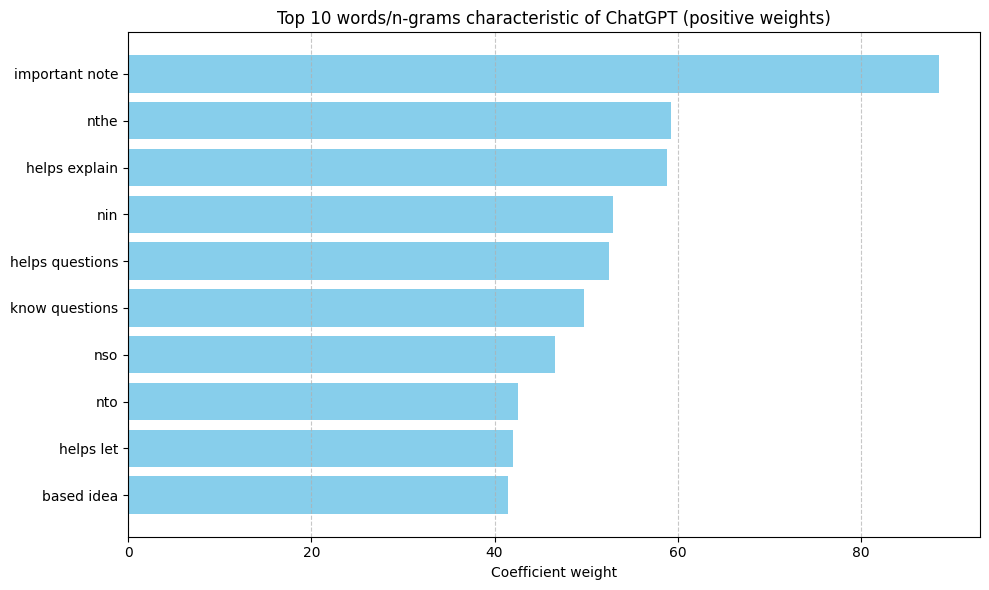

In [258]:
# Filtrer uniquement les poids positifs (typique LLM)
top_positive = feature_weights[feature_weights['Weight'] > 0].head(10)

# Barplot
plt.figure(figsize=(10,6))
plt.barh(top_positive['Feature'], top_positive['Weight'], color='skyblue')
plt.xlabel('Coefficient weight')
plt.title('Top 10 words/n-grams characteristic of ChatGPT (positive weights)')
plt.gca().invert_yaxis()  # Pour avoir le plus grand en haut
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Top 10 ChatGPT(positive weights).png')
plt.show()

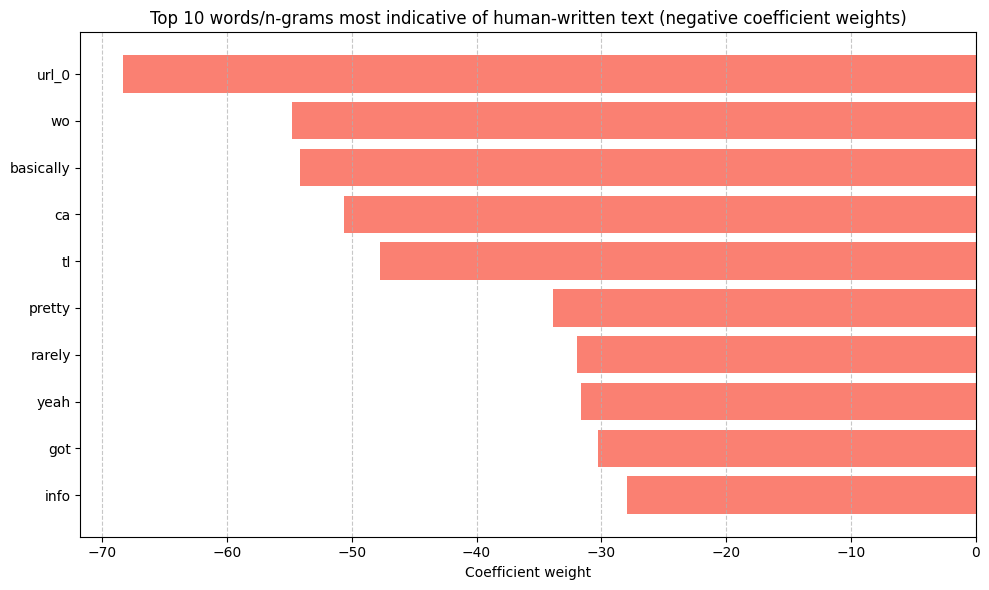

In [259]:
# Filtrer uniquement les poids négatifs (typique humain)
top_negative = feature_weights[feature_weights['Weight'] < 0].head(10)

# Barplot
plt.figure(figsize=(10,6))
plt.barh(top_negative['Feature'], top_negative['Weight'], color='salmon')
plt.xlabel('Coefficient weight')
plt.title('Top 10 words/n-grams most indicative of human-written text (negative coefficient weights)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Top 10 human-written text (negative coefficient weights).png')
plt.show()

## TF-IDF+Heuristic features+Logistic regression

In [252]:
# --- 1. Construction des textes et des labels ---

texts = df['human_answers'].tolist() + df['chatgpt_answers'].tolist()
y = [0] * len(df) + [1] * len(df)

# --- 2. Construction des features heuristiques ---

# Features humaines
features_human = df[['human_length', 'human_num_sentences', 'human_ttr']].copy()
features_human.columns = ['length', 'num_sentences', 'ttr']

# Features ChatGPT
features_chatgpt = df[['chatgpt_length', 'chatgpt_num_sentences', 'chatgpt_ttr']].copy()
features_chatgpt.columns = ['length', 'num_sentences', 'ttr']

# Combiner les deux en une seule matrice
heuristics = pd.concat([features_human, features_chatgpt], ignore_index=True)

# --- 3. Split Train/Test ---

texts_train, texts_test, heuristics_train, heuristics_test, y_train, y_test = train_test_split(
    texts, heuristics, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. TF-IDF Vectorisation ---

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(texts_train)
X_test_tfidf = vectorizer.transform(texts_test)

# --- 5. Standardisation des heuristics ---

scaler = StandardScaler()
X_train_heuristics = scaler.fit_transform(heuristics_train)
X_test_heuristics = scaler.transform(heuristics_test)

# --- 6. Concaténation des matrices ---

X_train_combined = hstack([X_train_tfidf, X_train_heuristics])
X_test_combined = hstack([X_test_tfidf, X_test_heuristics])

# --- 7. Cross-validation et entraînement du modèle ---

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)

grid_search = GridSearchCV(
    logreg,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_combined, y_train)

best_model_heur_tfidf = grid_search.best_estimator_

print("Meilleur C trouvé :", grid_search.best_params_)

# --- 8. Évaluation finale ---

y_pred = best_model_heur_tfidf.predict(X_test_combined)
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score : {roc_auc_score(y_test, best_model_heur_tfidf.predict_proba(X_test_combined)[:,1]):.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleur C trouvé : {'C': 10}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4524
           1       0.98      0.98      0.98      4524

    accuracy                           0.98      9048
   macro avg       0.98      0.98      0.98      9048
weighted avg       0.98      0.98      0.98      9048

ROC AUC Score : 0.9968


In [253]:
# 1. Récupérer les coefficients
coef = best_model_heur_tfidf.coef_[0]  # tableau 1D

# 2. Construire les noms des features
# D'abord les mots TF-IDF
tfidf_features = vectorizer.get_feature_names_out()

# Puis les features heuristiques
heuristic_features = ['length', 'num_sentences', 'ttr']

# Concaténer les deux
all_features = np.concatenate([tfidf_features, heuristic_features])

# 3. Mettre dans un DataFrame
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coef
})

# 4. Trier par valeur absolue du poids
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

# 5. Afficher les 20 features les plus importantes
print(coef_df_sorted[['Feature', 'Coefficient']].head(20))

            Feature  Coefficient
4594          url_0   -63.398746
4282           thus   -57.605883
687         can not   -53.001563
651              ca   -46.659001
462       basically   -46.396288
1158      does that    43.831700
1305            etc   -42.401485
2460        me know    41.012474
4867             wo   -36.379497
1853    imagine you    34.257074
3620      sorry but    32.815755
2694           nthe    32.670963
4395        to note    31.043439
2127   it important    30.649783
1315    even though    30.571916
1224           edit   -30.447449
3069  possible that    29.921496
1831        idea to    29.618565
4801   while others    28.935313
1332     example if    28.892773


In [255]:
# Indices des features heuristiques (après TF-IDF)
heuristic_features = ['length', 'num_sentences', 'ttr']
start_idx = len(vectorizer.get_feature_names_out())  # = 5000 normalement

# Récupérer les 3 coefficients
for i, feat in enumerate(heuristic_features):
    coef_value = best_model_heur_tfidf.coef_[0][start_idx + i]
    print(f"{feat:15s} →  Coefficient : {coef_value:+.4f}")

length          →  Coefficient : -0.9083
num_sentences   →  Coefficient : -0.7085
ttr             →  Coefficient : -2.8778


## BERT Embeddings+ Heuristics+ Logistic regression

In [260]:
from sentence_transformers import SentenceTransformer



texts = df['human_answers'].tolist() + df['chatgpt_answers'].tolist()
y = [0] * len(df) + [1] * len(df)



features_human = df[['human_length', 'human_num_sentences', 'human_ttr']].copy()
features_human.columns = ['length', 'num_sentences', 'ttr']

features_chatgpt = df[['chatgpt_length', 'chatgpt_num_sentences', 'chatgpt_ttr']].copy()
features_chatgpt.columns = ['length', 'num_sentences', 'ttr']

heuristics = pd.concat([features_human, features_chatgpt], ignore_index=True)



texts_train, texts_test, heuristics_train, heuristics_test, y_train, y_test = train_test_split(
    texts, heuristics, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. BERT Embedding ---

bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # léger et rapide
X_train_bert = bert_model.encode(texts_train, convert_to_tensor=False)
X_test_bert = bert_model.encode(texts_test, convert_to_tensor=False)



scaler = StandardScaler()
X_train_heuristics = scaler.fit_transform(heuristics_train)
X_test_heuristics = scaler.transform(heuristics_test)



X_train_combined = np.hstack([X_train_bert, X_train_heuristics])
X_test_combined = np.hstack([X_test_bert, X_test_heuristics])

# --- 7. Cross-validation et entraînement du modèle ---

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)

grid_search = GridSearchCV(
    logreg,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_combined, y_train)

best_model_bert_heur = grid_search.best_estimator_

print("Meilleur C trouvé :", grid_search.best_params_)

# --- 8. Évaluation finale ---

y_pred = best_model_bert_heur.predict(X_test_combined)
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score : {roc_auc_score(y_test, best_model_bert_heur.predict_proba(X_test_combined)[:,1]):.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment varia

Meilleur C trouvé : {'C': 1000}
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4524
           1       0.88      0.89      0.89      4524

    accuracy                           0.89      9048
   macro avg       0.89      0.89      0.89      9048
weighted avg       0.89      0.89      0.89      9048

ROC AUC Score : 0.9549
